# Assignment 2
Gargeya Sharma - 220278025 - M.Sc. Artificial Intelligence

### CNN with FashionMNIST

#### Importing all the necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm_notebook as tq
import matplotlib.pyplot as plt

#### Setting up the FashionMNIST data from torchvision.datasets

In [2]:
train_set = torchvision.datasets.FashionMNIST(root = ".", train=True,
download=True, transform=transforms.ToTensor())

test_set = torchvision.datasets.FashionMNIST(root = ".", train=False,
download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

# Fix the seed to be able to get the same randomness across runs and
# hence reproducible outcomes
torch.manual_seed(0)
# If you are using CuDNN, otherwise you can just ignore
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False

### 3.1

Cross Entropy Loss

### 3.2 

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ## Dense Layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        self.act3 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 256)
        self.act4 = nn.ReLU()
        self.linear3 = nn.Linear(256, 10)
        
    def forward(self, x):
        ## Convolutional Block 1
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        ## Convolutional Block 2
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ## Dense Layers
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act3(x)
        x = self.linear2(x)
        x = self.act4(x)
        x = self.linear3(x)
        
        return x

In [7]:
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

In [8]:

## Weight Initilization function using Xavier Initialization
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)

## Changing the underlying computation hardware between CPU or GPU (GPU, if its available)
model = CNN().to(device)
model.apply(init_weights)

#SGD Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.1)

## Maximum number of epochs to train the model with
epochs = 30

## As mentioned in the report, we are dealing with multi-class classification hence, CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()

## Evalutaion function to calculate evaluation metrics (in our case, Accuracy of prediction)
def evaluation(data_loader):
    model.eval()
    total_ = 0
    correct_ = 0
    for inputs, labels in data_loader:
        ## Change the Hardware of data to keep both the model and data on the same device
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = torch.argmax(model(inputs), dim=1)
        correct = (y_pred == labels).sum().item()
        total = labels.size(0)
        
        total_ += total
        correct_ += correct
    return round((correct_/total_)*100, 4)

In [9]:
train_loss = []
train_accs = []
test_accs = []
for epoch in tq(range(epochs)):
    for inputs, labels in train_loader:
        loss_per_epoch = 0
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()
    train_acc = evaluation(train_loader)
    test_acc = evaluation(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss.append(loss_per_epoch)
    print(f"Epoch: {epoch+1}, Loss: {loss_per_epoch:.4f}, Training Accuracy: {train_acc}%, Testing Accuracy:{test_acc}%")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.3944, Training Accuracy: 87.1533%, Testing Accuracy:86.13%
Epoch: 2, Loss: 0.1155, Training Accuracy: 90.0417%, Testing Accuracy:88.33%
Epoch: 3, Loss: 0.2658, Training Accuracy: 90.925%, Testing Accuracy:88.94%
Epoch: 4, Loss: 0.2860, Training Accuracy: 91.7033%, Testing Accuracy:89.47%
Epoch: 5, Loss: 0.0914, Training Accuracy: 93.24%, Testing Accuracy:90.56%
Epoch: 6, Loss: 0.0219, Training Accuracy: 93.24%, Testing Accuracy:90.03%
Epoch: 7, Loss: 0.1518, Training Accuracy: 93.9633%, Testing Accuracy:90.1%
Epoch: 8, Loss: 0.2375, Training Accuracy: 95.1967%, Testing Accuracy:90.83%
Epoch: 9, Loss: 0.2426, Training Accuracy: 95.4933%, Testing Accuracy:90.43%
Epoch: 10, Loss: 0.0514, Training Accuracy: 96.21%, Testing Accuracy:90.79%
Epoch: 11, Loss: 0.0679, Training Accuracy: 96.2767%, Testing Accuracy:90.78%
Epoch: 12, Loss: 0.1796, Training Accuracy: 96.6133%, Testing Accuracy:91.39%
Epoch: 13, Loss: 0.0793, Training Accuracy: 96.9633%, Testing Accuracy:90.52%
Epo

In [10]:
evaluation(train_loader)

98.4883

In [11]:
evaluation(test_loader)

89.76

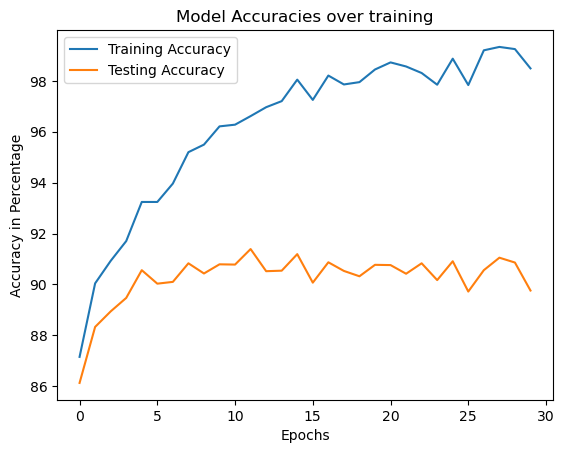

In [12]:
## Plotting of training and testing accuracies over 30 epochs
plt.plot(train_accs, label="Training Accuracy")
plt.plot(test_accs, label="Testing Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy in Percentage")
plt.title("Model Accuracies over training")
plt.show()

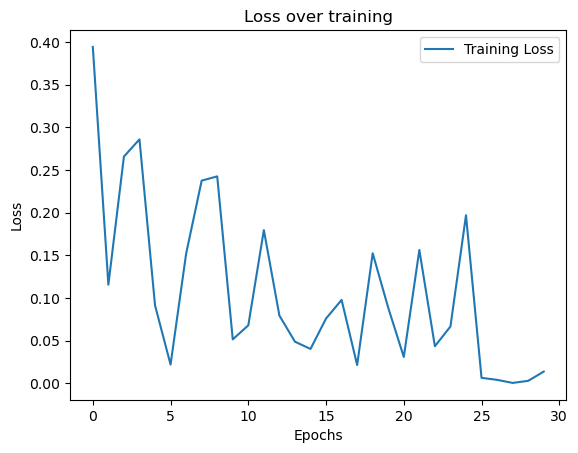

In [13]:
## Plotting of loss over the entire training of 30 epochs
plt.plot(train_loss, label="Training Loss")
plt.legend()
plt.title("Loss over training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

### 3.3

In [14]:
results = {}

#### Using Tanh Activation

In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        ## Change in activation Function
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        ## Change in activation Function
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ## Dense Layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        ## Change in activation Function
        self.act3 = nn.Tanh()
        self.linear2 = nn.Linear(1024, 256)
        ## Change in activation Function
        self.act4 = nn.Tanh()
        self.linear3 = nn.Linear(256, 10)
        
    def forward(self, x):
        ## Convolutional Block 1
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        ## Convolutional Block 2
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ## Dense Layers
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act3(x)
        x = self.linear2(x)
        x = self.act4(x)
        x = self.linear3(x)
        
        return x
    
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

## Rest of the code is same as mentioned and explained above

model = CNN().to(device)
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 30
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_accs = []
test_accs = []
for epoch in tq(range(epochs)):
    for inputs, labels in train_loader:
        loss_per_epoch = 0
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()
    train_acc = evaluation(train_loader)
    test_acc = evaluation(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss.append(loss_per_epoch)
    print(f"Epoch: {epoch+1}, Loss: {loss_per_epoch:.4f}, Training Accuracy: {train_acc}%, Testing Accuracy:{test_acc}%")
    
results["Tanh"] = {"Training Accuracy": evaluation(train_loader), "Testing Accuracy": evaluation(test_loader)}

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.4675, Training Accuracy: 88.785%, Testing Accuracy:87.41%
Epoch: 2, Loss: 0.3473, Training Accuracy: 89.385%, Testing Accuracy:87.58%
Epoch: 3, Loss: 0.1556, Training Accuracy: 92.1217%, Testing Accuracy:89.82%
Epoch: 4, Loss: 0.1776, Training Accuracy: 92.855%, Testing Accuracy:89.79%
Epoch: 5, Loss: 0.2463, Training Accuracy: 93.595%, Testing Accuracy:89.96%
Epoch: 6, Loss: 0.1475, Training Accuracy: 94.3917%, Testing Accuracy:89.91%
Epoch: 7, Loss: 0.1130, Training Accuracy: 95.18%, Testing Accuracy:90.29%
Epoch: 8, Loss: 0.2025, Training Accuracy: 94.6617%, Testing Accuracy:89.95%
Epoch: 9, Loss: 0.3190, Training Accuracy: 96.505%, Testing Accuracy:90.29%
Epoch: 10, Loss: 0.1514, Training Accuracy: 97.4683%, Testing Accuracy:90.82%
Epoch: 11, Loss: 0.0602, Training Accuracy: 96.4667%, Testing Accuracy:89.61%
Epoch: 12, Loss: 0.0438, Training Accuracy: 98.0583%, Testing Accuracy:90.97%
Epoch: 13, Loss: 0.0166, Training Accuracy: 98.8217%, Testing Accuracy:90.84%
Ep

In [17]:
results

{'Tanh': {'Training Accuracy': 100.0, 'Testing Accuracy': 91.56}}

#### Using Sigmoid Activation

In [18]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        ## Change in activation Function
        self.act1 = nn.Sigmoid()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        ## Change in activation Function
        self.act2 = nn.Sigmoid()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ## Dense Layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        ## Change in activation Function
        self.act3 = nn.Sigmoid()
        self.linear2 = nn.Linear(1024, 256)
        ## Change in activation Function
        self.act4 = nn.Sigmoid()
        self.linear3 = nn.Linear(256, 10)
        
    def forward(self, x):
        ## Convolutional Block 1
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        ## Convolutional Block 2
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ## Dense Layers
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act3(x)
        x = self.linear2(x)
        x = self.act4(x)
        x = self.linear3(x)
        
        return x
    
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

model = CNN().to(device)
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 30
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_accs = []
test_accs = []
for epoch in tq(range(epochs)):
    for inputs, labels in train_loader:
        loss_per_epoch = 0
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()
    train_acc = evaluation(train_loader)
    test_acc = evaluation(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss.append(loss_per_epoch)
    print(f"Epoch: {epoch+1}, Loss: {loss_per_epoch:.4f}, Training Accuracy: {train_acc}%, Testing Accuracy:{test_acc}%")
    
results["Sigmoid"] = {"Training Accuracy": evaluation(train_loader), "Testing Accuracy": evaluation(test_loader)}

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 1.7209, Training Accuracy: 47.4383%, Testing Accuracy:47.21%
Epoch: 2, Loss: 0.5739, Training Accuracy: 71.7017%, Testing Accuracy:71.22%
Epoch: 3, Loss: 0.5686, Training Accuracy: 73.6933%, Testing Accuracy:72.54%
Epoch: 4, Loss: 0.4211, Training Accuracy: 74.78%, Testing Accuracy:74.08%
Epoch: 5, Loss: 0.5046, Training Accuracy: 77.745%, Testing Accuracy:77.2%
Epoch: 6, Loss: 0.4140, Training Accuracy: 80.1567%, Testing Accuracy:79.51%
Epoch: 7, Loss: 0.3965, Training Accuracy: 80.9767%, Testing Accuracy:80.35%
Epoch: 8, Loss: 0.4853, Training Accuracy: 82.575%, Testing Accuracy:81.46%
Epoch: 9, Loss: 0.5357, Training Accuracy: 84.48%, Testing Accuracy:83.86%
Epoch: 10, Loss: 0.3333, Training Accuracy: 86.1067%, Testing Accuracy:84.89%
Epoch: 11, Loss: 0.6440, Training Accuracy: 86.69%, Testing Accuracy:85.71%
Epoch: 12, Loss: 0.1609, Training Accuracy: 86.6617%, Testing Accuracy:85.36%
Epoch: 13, Loss: 0.2052, Training Accuracy: 86.73%, Testing Accuracy:85.81%
Epoch:

In [19]:
results

{'Tanh': {'Training Accuracy': 100.0, 'Testing Accuracy': 91.56},
 'Sigmoid': {'Training Accuracy': 90.8417, 'Testing Accuracy': 89.12}}

#### Using ELU Activation

In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        ## Change in activation Function
        self.act1 = nn.ELU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        ## Change in activation Function
        self.act2 = nn.ELU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ## Dense Layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        ## Change in activation Function
        self.act3 = nn.ELU()
        self.linear2 = nn.Linear(1024, 256)
        ## Change in activation Function
        self.act4 = nn.ELU()
        self.linear3 = nn.Linear(256, 10)
        
    def forward(self, x):
        ## Convolutional Block 1
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        ## Convolutional Block 2
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ## Dense Layers
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act3(x)
        x = self.linear2(x)
        x = self.act4(x)
        x = self.linear3(x)
        
        return x
    
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

model = CNN().to(device)
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 30
loss_fn = nn.CrossEntropyLoss()

train_loss = []
train_accs = []
test_accs = []
for epoch in tq(range(epochs)):
    for inputs, labels in train_loader:
        loss_per_epoch = 0
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()
    train_acc = evaluation(train_loader)
    test_acc = evaluation(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss.append(loss_per_epoch)
    print(f"Epoch: {epoch+1}, Loss: {loss_per_epoch:.4f}, Training Accuracy: {train_acc}%, Testing Accuracy:{test_acc}%")
    
results["ELU"] = {"Training Accuracy": evaluation(train_loader), "Testing Accuracy": evaluation(test_loader)}

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.3437, Training Accuracy: 89.17%, Testing Accuracy:87.58%
Epoch: 2, Loss: 0.2279, Training Accuracy: 91.3433%, Testing Accuracy:89.21%
Epoch: 3, Loss: 0.2340, Training Accuracy: 92.305%, Testing Accuracy:89.49%
Epoch: 4, Loss: 0.2560, Training Accuracy: 93.5833%, Testing Accuracy:90.44%
Epoch: 5, Loss: 0.1969, Training Accuracy: 93.8517%, Testing Accuracy:90.1%
Epoch: 6, Loss: 0.2378, Training Accuracy: 94.3533%, Testing Accuracy:90.42%
Epoch: 7, Loss: 0.1985, Training Accuracy: 94.98%, Testing Accuracy:90.4%
Epoch: 8, Loss: 0.1562, Training Accuracy: 96.1983%, Testing Accuracy:90.39%
Epoch: 9, Loss: 0.0818, Training Accuracy: 96.7167%, Testing Accuracy:90.54%
Epoch: 10, Loss: 0.1852, Training Accuracy: 95.9267%, Testing Accuracy:89.58%
Epoch: 11, Loss: 0.1411, Training Accuracy: 96.7283%, Testing Accuracy:90.24%
Epoch: 12, Loss: 0.0090, Training Accuracy: 97.485%, Testing Accuracy:90.55%
Epoch: 13, Loss: 0.2053, Training Accuracy: 96.585%, Testing Accuracy:89.84%
Epoc

In [23]:
results

{'Tanh': {'Training Accuracy': 100.0, 'Testing Accuracy': 91.56},
 'Sigmoid': {'Training Accuracy': 90.8417, 'Testing Accuracy': 89.12},
 'ELU': {'Training Accuracy': 98.4133, 'Testing Accuracy': 90.26}}

### 3.4

In [24]:
lr_experiment = {}
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ## Dense Layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        self.act3 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 256)
        self.act4 = nn.ReLU()
        self.linear3 = nn.Linear(256, 10)
        
    def forward(self, x):
        ## Convolutional Block 1
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        ## Convolutional Block 2
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ## Dense Layers
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act3(x)
        x = self.linear2(x)
        x = self.act4(x)
        x = self.linear3(x)
        
        return x
    
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

model = CNN().to(device)
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 30
loss_fn = nn.CrossEntropyLoss()
for lr_ in [0.001, 0.1, 0.5, 1, 10]:
    ## Iterating over the different learning rates in the list above
    optimizer = optim.SGD(model.parameters(), lr=lr_)
    train_loss = []
    train_accs = []
    test_accs = []
    for epoch in tq(range(epochs)):
        for inputs, labels in train_loader:
            loss_per_epoch = 0
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            y_pred = model(inputs)
            loss = loss_fn(y_pred, labels)
            loss.backward()
            optimizer.step()

            loss_per_epoch += loss.item()
        train_acc = evaluation(train_loader)
        test_acc = evaluation(test_loader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_loss.append(loss_per_epoch)
        print(f"Epoch: {epoch+1}, Loss: {loss_per_epoch:.4f}, Training Accuracy: {train_acc}%, Testing Accuracy:{test_acc}%")

    lr_experiment[str(lr_)] = {"Loss": train_loss, "Training Accuracy": train_accs, "Testing Accuracy": test_accs}

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.7171, Training Accuracy: 71.33%, Testing Accuracy:70.31%
Epoch: 2, Loss: 0.5854, Training Accuracy: 74.57%, Testing Accuracy:73.9%
Epoch: 3, Loss: 0.6863, Training Accuracy: 77.23%, Testing Accuracy:75.71%
Epoch: 4, Loss: 0.6432, Training Accuracy: 76.7867%, Testing Accuracy:75.41%
Epoch: 5, Loss: 0.7378, Training Accuracy: 79.53%, Testing Accuracy:78.24%
Epoch: 6, Loss: 0.6968, Training Accuracy: 80.595%, Testing Accuracy:79.75%
Epoch: 7, Loss: 0.4884, Training Accuracy: 82.1383%, Testing Accuracy:81.04%
Epoch: 8, Loss: 0.4627, Training Accuracy: 83.0367%, Testing Accuracy:82.0%
Epoch: 9, Loss: 0.3730, Training Accuracy: 82.29%, Testing Accuracy:81.17%
Epoch: 10, Loss: 0.2724, Training Accuracy: 84.285%, Testing Accuracy:83.23%
Epoch: 11, Loss: 0.3898, Training Accuracy: 84.3283%, Testing Accuracy:83.75%
Epoch: 12, Loss: 0.4479, Training Accuracy: 83.1017%, Testing Accuracy:81.89%
Epoch: 13, Loss: 0.5251, Training Accuracy: 84.9517%, Testing Accuracy:84.13%
Epoch: 14

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.3692, Training Accuracy: 88.61%, Testing Accuracy:87.09%
Epoch: 2, Loss: 0.3751, Training Accuracy: 90.9283%, Testing Accuracy:89.37%
Epoch: 3, Loss: 0.3623, Training Accuracy: 90.5533%, Testing Accuracy:88.79%
Epoch: 4, Loss: 0.1558, Training Accuracy: 91.88%, Testing Accuracy:89.56%
Epoch: 5, Loss: 0.3255, Training Accuracy: 93.12%, Testing Accuracy:90.14%
Epoch: 6, Loss: 0.1851, Training Accuracy: 93.7767%, Testing Accuracy:90.68%
Epoch: 7, Loss: 0.3014, Training Accuracy: 91.6683%, Testing Accuracy:88.59%
Epoch: 8, Loss: 0.1190, Training Accuracy: 95.3733%, Testing Accuracy:91.09%
Epoch: 9, Loss: 0.1432, Training Accuracy: 95.4933%, Testing Accuracy:90.78%
Epoch: 10, Loss: 0.0478, Training Accuracy: 95.5383%, Testing Accuracy:90.29%
Epoch: 11, Loss: 0.0493, Training Accuracy: 95.6533%, Testing Accuracy:90.06%
Epoch: 12, Loss: 0.1573, Training Accuracy: 97.1683%, Testing Accuracy:91.11%
Epoch: 13, Loss: 0.3040, Training Accuracy: 97.255%, Testing Accuracy:90.6%
Epo

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 2, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 3, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 4, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 5, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 6, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 7, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 8, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 9, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 10, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 11, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 12, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 13, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 14, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 15, Loss

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 2, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 3, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 4, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 5, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 6, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 7, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 8, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 9, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 10, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 11, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 12, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 13, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 14, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 15, Loss

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 2, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 3, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 4, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 5, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 6, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 7, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 8, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 9, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 10, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 11, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 12, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 13, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 14, Loss: nan, Training Accuracy: 10.0%, Testing Accuracy:10.0%
Epoch: 15, Loss

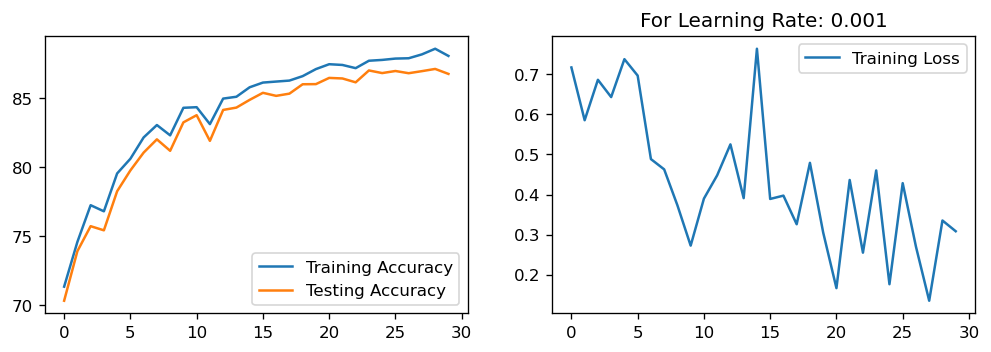

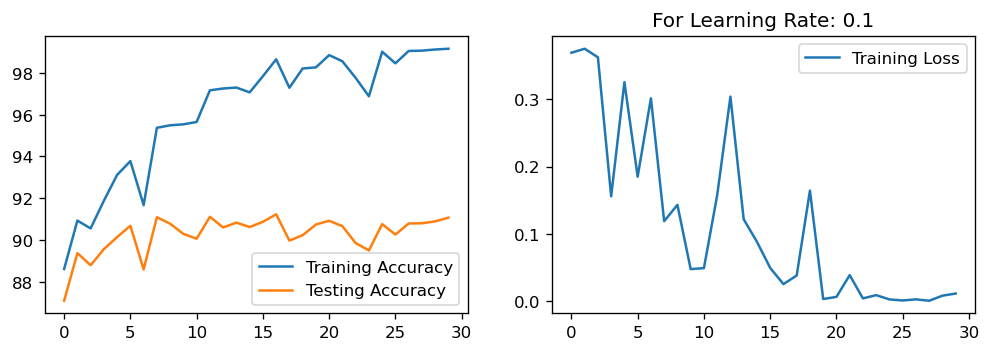

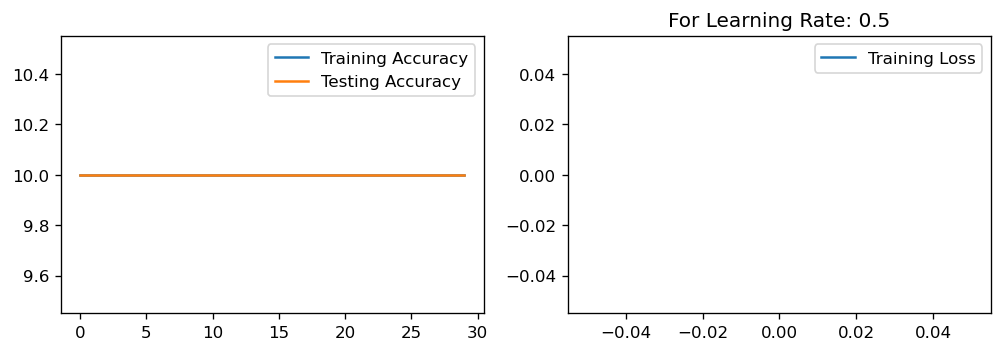

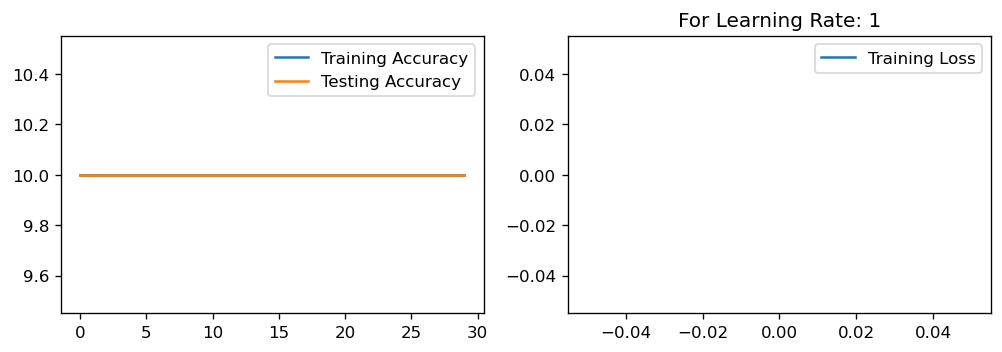

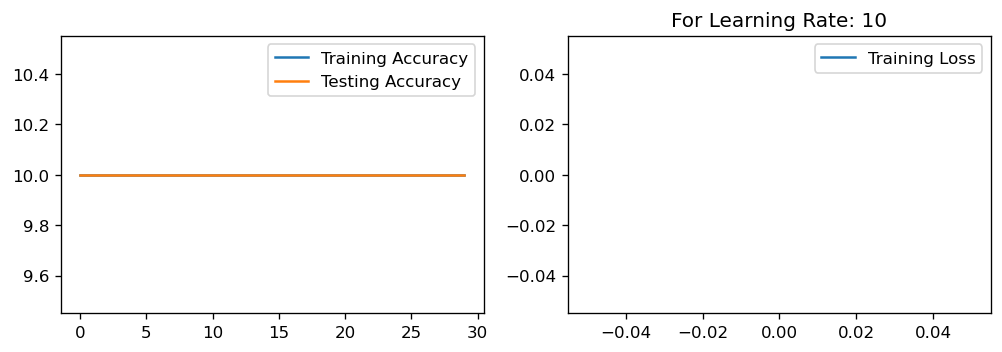

In [25]:
for lr, values in lr_experiment.items():
    fig,ax = plt.subplots(1, 2, dpi=120, figsize=(10,3))
    ax[0].plot(values["Training Accuracy"], label="Training Accuracy")
    ax[0].plot(values["Testing Accuracy"], label="Testing Accuracy")
    ax[0].legend()
    ax[1].plot(values["Loss"], label="Training Loss")
    plt.title(f"For Learning Rate: {lr}")
    ax[1].legend()
    plt.show()

In [35]:
lr_experiment.keys()

dict_keys(['0.001', '0.1', '0.5', '1', '10'])

### 3.5

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        ## Convolutional Block 1
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        ## Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        ## Dense Layers
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(1024, 1024)
        self.act3 = nn.ReLU()
        self.linear2 = nn.Linear(1024, 256)
        
        ## Dropout layer with p=0.3 
        self.dropout = nn.Dropout(0.3)
        
        self.act4 = nn.ReLU()
        self.linear3 = nn.Linear(256, 10)
        
    def forward(self, x):
        ## Convolutional Block 1
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        ## Convolutional Block 2
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        ## Dense Layers
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.act3(x)
        x = self.linear2(x)
        x = self.dropout(x)
        x = self.act4(x)
        x = self.linear3(x)
        
        return x
    
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")

model = CNN().to(device)
model.apply(init_weights)
optimizer = optim.SGD(model.parameters(), lr=0.1)
epochs = 30
loss_fn = nn.CrossEntropyLoss()
train_loss = []
train_accs = []
test_accs = []
for epoch in tq(range(epochs)):
    for inputs, labels in train_loader:
        loss_per_epoch = 0
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()

        loss_per_epoch += loss.item()
    train_acc = evaluation(train_loader)
    test_acc = evaluation(test_loader)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    train_loss.append(loss_per_epoch)
    print(f"Epoch: {epoch+1}, Loss: {loss_per_epoch:.4f}, Training Accuracy: {train_acc}%, Testing Accuracy:{test_acc}%")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.3050, Training Accuracy: 88.3483%, Testing Accuracy:86.82%
Epoch: 2, Loss: 0.2137, Training Accuracy: 89.98%, Testing Accuracy:88.37%
Epoch: 3, Loss: 0.5287, Training Accuracy: 91.54%, Testing Accuracy:89.53%
Epoch: 4, Loss: 0.0742, Training Accuracy: 91.94%, Testing Accuracy:89.54%
Epoch: 5, Loss: 0.1282, Training Accuracy: 93.1667%, Testing Accuracy:90.03%
Epoch: 6, Loss: 0.1424, Training Accuracy: 93.675%, Testing Accuracy:89.99%
Epoch: 7, Loss: 0.1232, Training Accuracy: 94.6017%, Testing Accuracy:91.01%
Epoch: 8, Loss: 0.1988, Training Accuracy: 95.19%, Testing Accuracy:90.88%
Epoch: 9, Loss: 0.0668, Training Accuracy: 95.5617%, Testing Accuracy:90.53%
Epoch: 10, Loss: 0.1023, Training Accuracy: 95.3433%, Testing Accuracy:90.01%
Epoch: 11, Loss: 0.1791, Training Accuracy: 96.0117%, Testing Accuracy:90.21%
Epoch: 12, Loss: 0.0023, Training Accuracy: 97.025%, Testing Accuracy:90.96%
Epoch: 13, Loss: 0.1160, Training Accuracy: 97.175%, Testing Accuracy:90.63%
Epoch:

In [50]:
evaluation(train_loader)

98.4583

In [51]:
evaluation(test_loader)

90.04

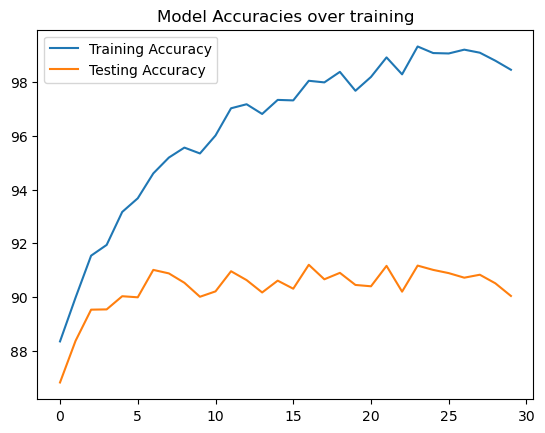

In [48]:
plt.plot(train_accs, label="Training Accuracy")
plt.plot(test_accs, label="Testing Accuracy")
plt.legend()
plt.title("Model Accuracies over training")
plt.show()

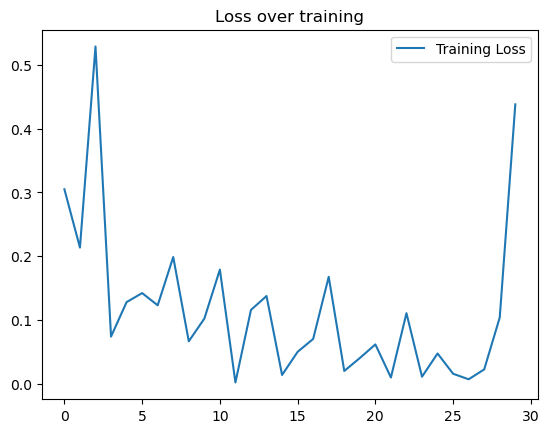

In [49]:
plt.plot(train_loss, label="Training Loss")
plt.legend()
plt.title("Loss over training")
plt.show()